In [34]:
# This code uses the Gradient Boosting model generated with the training data to
# predict sales values for the real-life data provided by the teachers.

# This cell imports the necessary libraries

import pandas as pd
import numpy as np

# Visualization Tools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing Libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures

# Modeling Libraries
from sklearn.linear_model import LinearRegression
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import xgboost as xgb

# About Keras
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam

# Model Selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# Feature Selection
from sklearn.feature_selection import SelectKBest, f_regression

# Performance Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# More Visualizations 
from sklearn.tree import export_graphviz
from sklearn import tree
from IPython.display import SVG,display
from graphviz import Source

# Managing Warnings
import warnings
warnings.filterwarnings('ignore')


In [36]:
# Data Preparation and Cleaning

# Loads the Dataset
file_path = '/Users/sylviaperez-montero/Desktop/nbs-5-master-master/ironkaggle/Real data/REAL_DATA.csv' 
real_data = pd.read_csv(file_path)

# Displays the column names and the top 5 rows of data
real_data.head()

# Checks the number of rows and columns
print("Number of rows are: ",real_data.shape[0])
print("Number of columns are: ",real_data.shape[1])

# Dataset Information
real_data.info()

# Looks for duplicate records
dups = real_data.duplicated().sum()
print(f'There are {dups} duplicated rows in the data')

# Counts missing/null values
real_data.isnull().sum()

# Looks at the columns
real_data.columns

# Presents the unique values in all columns except the sales column

# Columns to check for unique values
columns_to_check = ['day_of_week', 'date', 'nb_customers_on_day','open', 'promotion', 'state_holiday', 'school_holiday']

# Iterate over the columns and display unique value counts
for column in columns_to_check:
    if column in real_data.columns:
        unique_values = real_data[column].unique()
        num_unique_values = real_data[column].nunique()
        print(f"No. of unique values in {column} is {num_unique_values}")
        print(f"Unique values in {column}: {unique_values}\n")
    else:
        print(f"Column '{column}' not found in the DataFrame.\n")

Number of rows are:  71205
Number of columns are:  11
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71205 entries, 0 to 71204
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                71205 non-null  int64  
 1   store_ID             71205 non-null  int64  
 2   day_of_week          71205 non-null  int64  
 3   date                 71205 non-null  object 
 4   nb_customers_on_day  71205 non-null  int64  
 5   open                 71205 non-null  int64  
 6   promotion            71205 non-null  int64  
 7   state_holiday        71205 non-null  object 
 8   school_holiday       71205 non-null  int64  
 9   predicted_sales      71205 non-null  float64
 10  Unnamed: 10          0 non-null      float64
dtypes: float64(2), int64(7), object(2)
memory usage: 6.0+ MB
There are 0 duplicated rows in the data
No. of unique values in day_of_week is 7
Unique values in day_of_week: [7 3 2 4 1 6 5

In [38]:
import pandas as pd

pd.set_option('future.no_silent_downcasting', True)

state_holiday_mapping = {'a': 1, 'b': 1, 'c': 1, 'd': 1, '0': 0}
real_data['state_holiday'] = real_data['state_holiday'].replace(state_holiday_mapping)

# Recodes unique values in state_holiday and day_of_week
# Recode values 'a', 'b', 'c', 'd' in 'state_holiday' as 1
state_holiday_mapping = {'a': 1, 'b': 1, 'c': 1, 'd': 1, '0': 0}
real_data['state_holiday'] = real_data['state_holiday'].replace(state_holiday_mapping)

# Displays the first few rows to verify the changes
#print("Updated 'state_holiday' column:")
print(real_data['state_holiday'].unique())
real_data.head()

[0 1]


,index,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,predicted_sales,Unnamed: 10
0,272371,415,7,1/3/15,0,0,0,0,0,1.34,NaN
1,558468,27,7,29/12/2013,0,0,0,0,0,1.34,NaN
2,76950,404,3,19/03/2014,657,1,1,0,0,6960.91,NaN
3,77556,683,2,29/01/2013,862,1,0,0,0,7147.28,NaN
4,456344,920,3,19/03/2014,591,1,1,0,0,6372.86,NaN


In [40]:
# Ensure 'day_of_week' is a string
real_data['day_of_week'] = real_data['day_of_week'].astype(str)

# Display the first few rows for verification
print(real_data.head())

# Display DataFrame info
print(real_data.info())

    index  store_ID day_of_week        date  nb_customers_on_day  open  \
0  272371       415           7      1/3/15                    0     0   
1  558468        27           7  29/12/2013                    0     0   
2   76950       404           3  19/03/2014                  657     1   
3   77556       683           2  29/01/2013                  862     1   
4  456344       920           3  19/03/2014                  591     1   

   promotion state_holiday  school_holiday  predicted_sales  Unnamed: 10  
0          0             0               0             1.34          NaN  
1          0             0               0             1.34          NaN  
2          1             0               0          6960.91          NaN  
3          0             0               0          7147.28          NaN  
4          1             0               0          6372.86          NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71205 entries, 0 to 71204
Data columns (total 11 column

In [42]:
import pandas as pd

# Assuming the dataset is already loaded into real_data
# Ensure the 'date' column is a string
real_data['date'] = real_data['date'].astype(str)

# Parse the 'date' column and handle both formats (DD/MM/YYYY and DD/MM/YY)
real_data['parsed_date'] = pd.to_datetime(real_data['date'], dayfirst=True, errors='coerce')

# Extract the month from the parsed date and append it as a new column
real_data['month'] = real_data['parsed_date'].dt.month.astype(str).str.zfill(2)

# Drop the parsed_date column (optional)
real_data.drop(columns=['parsed_date'], inplace=True)

# Display the first few rows for verification
print(real_data.head())

# Display DataFrame info to confirm the addition of the 'month' column
print(real_data.info())

print(real_data.columns)

print(real_data['month'].unique())

# Encodes month and day_of_week variables using one-hot encoding

# One-hot encoding the 'day_of_week' and 'month' columns
encoded_data = pd.get_dummies(real_data, columns=['day_of_week', 'month'], drop_first=False)

# Display the new DataFrame with one-hot encoded columns
print(encoded_data.head())
print(encoded_data.info())

# Drops the date column (no longer needed)
encoded_data.drop(['date'], axis=1, inplace=True)
%store encoded_data

# Save encoded_data as a CSV file
encoded_data.to_csv('/Users/sylviaperez-montero/Desktop/nbs-5-master-master/ironkaggle/Real Data/encoded_data.csv', index=False)  


    index  store_ID day_of_week        date  nb_customers_on_day  open  \
0  272371       415           7      1/3/15                    0     0   
1  558468        27           7  29/12/2013                    0     0   
2   76950       404           3  19/03/2014                  657     1   
3   77556       683           2  29/01/2013                  862     1   
4  456344       920           3  19/03/2014                  591     1   

   promotion state_holiday  school_holiday  predicted_sales  Unnamed: 10 month  
0          0             0               0             1.34          NaN    03  
1          0             0               0             1.34          NaN    12  
2          1             0               0          6960.91          NaN    03  
3          0             0               0          7147.28          NaN    01  
4          1             0               0          6372.86          NaN    03  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71205 entries, 0 to

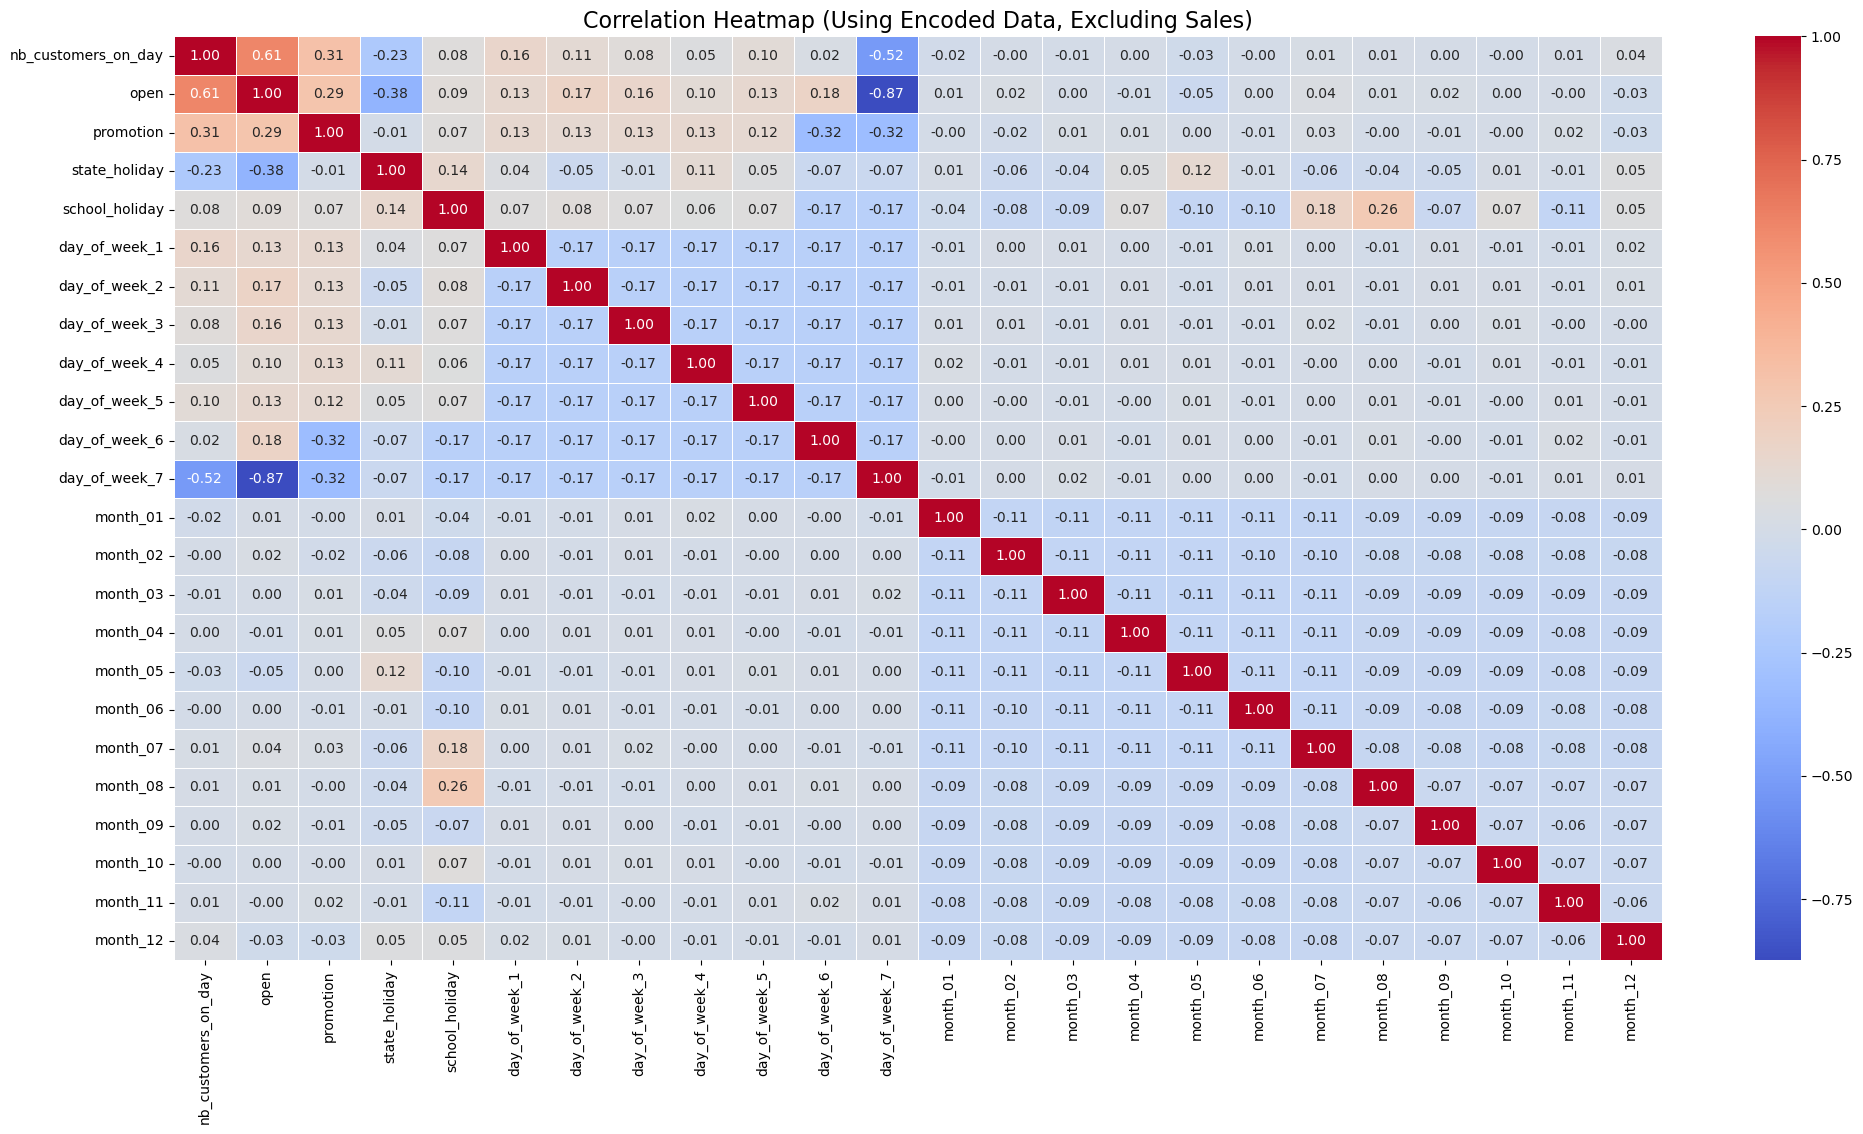

In [44]:
# Generates a correlation heatmap

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Selects all columns from encoded_data
correlation_columns = [
    'nb_customers_on_day', 'open', 'promotion', 'state_holiday', 'school_holiday',
    'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
    'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
    'month_01', 'month_02', 'month_03', 'month_04', 'month_05', 'month_06',
    'month_07', 'month_08', 'month_09', 'month_10', 'month_11', 'month_12'
]

# Calculates the correlation matrix using encoded_data
correlation_matrix = encoded_data[correlation_columns].corr()

# Creates a heatmap
plt.figure(figsize=(24, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)

# Adds titles and labels
plt.title("Correlation Heatmap (Using Encoded Data, Excluding Sales)", fontsize=16)
plt.show()

In [47]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
import joblib

# Defines file paths
file_path = "/Users/sylviaperez-montero/Desktop/nbs-5-master-master/ironkaggle/Real data/encoded_data.csv"
scaler_path = "/Users/sylviaperez-montero/Desktop/nbs-5-master-master/ironkaggle/Training & Model Definition/scaler.pkl"
model_path = "/Users/sylviaperez-montero/Desktop/nbs-5-master-master/ironkaggle/Training & Model Definition/gbr_model.pkl"
output_file_path = "/Users/sylviaperez-montero/Desktop/nbs-5-master-master/ironkaggle/Real data/encoded_data_with_predictions.csv"

# Loads the encoded data
try:
    encoded_data = pd.read_csv(file_path)
    if encoded_data.empty:
        raise ValueError("The encoded data file is empty or not loaded correctly.")
except FileNotFoundError as e:
    raise FileNotFoundError(f"File not found at {file_path}: {e}")
except pd.errors.EmptyDataError as e:
    raise ValueError(f"Error reading the file: {e}")

# Keeps only the specified columns by name
try:
    encoded_data = encoded_data[['nb_customers_on_day', 'open', 'promotion', 'state_holiday', 'day_of_week_7']]
except KeyError as e:
    raise KeyError(f"Error selecting columns by name. Ensure these columns exist in the dataset: {e}")

# Validates and transforms 'day_of_week_7' to contain only 1 (True) or 0 (False)
try:
    encoded_data['day_of_week_7'] = encoded_data['day_of_week_7'].apply(
        lambda x: 1 if x in [1, True] else 0
    )
except KeyError as e:
    raise KeyError(f"'day_of_week_7' column not found in the data: {e}")
except Exception as e:
    raise Exception(f"Unexpected error processing 'day_of_week_7': {e}")

# Dynamically drop 'actual_sales' if it exists, keeping all other columns as features
# Note: y_true is not defined since only predictions are required
X_new = encoded_data.drop(columns=['actual_sales'], errors='ignore')

# Loads the scaler and Gradient Boosting model
try:
    scaler = joblib.load(scaler_path)
    gbr_model = joblib.load(model_path)
except FileNotFoundError as e:
    raise FileNotFoundError(f"Error loading scaler or model file: {e}")
except Exception as e:
    raise Exception(f"Unexpected error loading the scaler or model: {e}")

# Prepares the data for prediction
try:
    X_new_scaled = scaler.transform(X_new)
except ValueError as e:
    raise ValueError(f"Error during scaling. Ensure the input data matches the scaler's expectations: {e}")

# Makes predictions
try:
    predicted_sales = gbr_model.predict(X_new_scaled)
except ValueError as e:
    raise ValueError(f"Error during prediction. Ensure the input data matches the model's expectations: {e}")

# Adds predictions to the DataFrame
encoded_data['predicted_sales'] = predicted_sales

# Saves the updated DataFrame to a new CSV file
try:
    encoded_data.to_csv(output_file_path, index=False)
    print(f"Predictions added. Saved updated file to {output_file_path}")
except Exception as e:
    raise IOError(f"Error saving the updated file to {output_file_path}: {e}")

# Displays the first few rows of the updated DataFrame
print(encoded_data.head())

Predictions added. Saved updated file to /Users/sylviaperez-montero/Desktop/nbs-5-master-master/ironkaggle/Real data/encoded_data_with_predictions.csv
   nb_customers_on_day  open  promotion  state_holiday  day_of_week_7  \
0                    0     0          0              0              1   
1                    0     0          0              0              1   
2                  657     1          1              0              0   
3                  862     1          0              0              0   
4                  591     1          1              0              0   

   predicted_sales  
0         1.335691  
1         1.335691  
2      6960.905578  
3      7147.283133  
4      6372.855308  


# **The expected R-squared for this model is: 0.87**